Our baseline model using orbit-ml (damped local trend/DLT) to predict bike availability in the Toronto bikeshare system.

In [ ]:
# Reference: https://github.com/uber/orbit/blob/dev/examples/dlt_daily_forecast.ipynb

In [ ]:
!pip install orbit-ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.9/445.9 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 11.5 MB/s eta 0:00:00
  Created wheel for orbit-ml: filename=orbit_ml-1.1.4.2-py3-none-any.whl size=475068 sha256=51a0d8e217b219e2fccb7e15df854c63dca6184a9ec7c411d72fb418a9d4bfd2
  Stored in directory: /root/.cache/pip/wheels/d6/d5/12/29fb5179003c5899b3a9281d268f9579df35bb263b985c6456
Successfully built orbit-ml


# Baseline - DLT

In [ ]:
import pandas as pd
import numpy as np
import ssl

from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
# to make fourier series for annual seasonality
from orbit.utils.features import make_fourier_series_df
from orbit.utils.dataset import load_electricity_demand, load_m5daily
from orbit.utils.params_tuning import generate_param_args_list

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# open this folder and add to shortcut https://drive.google.com/drive/folders/15J0TrAl6luJlbUcrW22-ca8oUpx1v4Ru?usp=sharing
%cd <path to bikeshare_availability_prediction folder>
#%cd /content/drive/.shortcut-targets-by-id/1eHfo448LIm58sxpXztXwS5IHIe6Skl_A/ECE1724_Project/Final/FinalSubmission/ece1724FinalColabNotebooks/bikeshare_availability_prediction

/content/drive/.shortcut-targets-by-id/1eHfo448LIm58sxpXztXwS5IHIe6Skl_A/ECE1724_Project/Final/FinalSubmission/ece1724FinalColabNotebooks/bikeshare_availability_prediction


In [ ]:
import requests
df=pd.read_csv("./dataset/bikeshare_availability_dataset.csv")
df['Time'] = pd.to_datetime(df['Time'])
df['station_id']=df['station_id'].astype(int)
url = "https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information"
# Send an HTTP GET request to retrieve the JSON data
response = requests.get(url)

if response.status_code == 200:
    # Parse the JSON data into a dictionary
    file_data = response.json()

    # Extract the 'stations' data and create a DataFrame
    stations_data = file_data.get('data', {}).get('stations', [])
    stations_df = pd.DataFrame(stations_data)
else:
    print(f"Failed to retrieve data from the URL. Status code: {response.status_code}")
stations_df['station_id']=stations_df['station_id'].astype(int)
df = pd.merge(df,stations_df[["station_id", "name", "address", "lat", "lon"]],on='station_id',how='left')
df['availability'] = df['bikes_available'] / df['capacity']
df['availability'] = df['availability'].fillna(0)
df = df.drop(columns=['lat_y', 'lon_y'])
df = df.rename(columns={"lat_x":"lat", "lon_x":"lon"})
# hourly for March

This model is unable to encode all stations. Therefore we need to train a different model for each station. This is inefficient, however we select a station (station 7001) as an example to evaluate its performance.

In [ ]:
df = df.loc[df['station_id']==7001]

In [ ]:
df

,station_id,lat,lon,Time,Hour,capacity,bikes_available,name,address,availability
744,7001,43.664964,-79.38355,2023-03-01 00:00:00,0,23,14.0,Wellesley Station Green P,Yonge / Wellesley,0.608696
745,7001,43.664964,-79.38355,2023-03-01 01:00:00,1,23,12.0,Wellesley Station Green P,Yonge / Wellesley,0.521739
746,7001,43.664964,-79.38355,2023-03-01 02:00:00,2,23,12.0,Wellesley Station Green P,Yonge / Wellesley,0.521739
747,7001,43.664964,-79.38355,2023-03-01 03:00:00,3,23,12.0,Wellesley Station Green P,Yonge / Wellesley,0.521739
748,7001,43.664964,-79.38355,2023-03-01 04:00:00,4,23,12.0,Wellesley Station Green P,Yonge / Wellesley,0.521739
...,...,...,...,...,...,...,...,...,...,...
1483,7001,43.664964,-79.38355,2023-03-31 19:00:00,19,23,11.0,Wellesley Station Green P,Yonge / Wellesley,0.478261
1484,7001,43.664964,-79.38355,2023-03-31 20:00:00,20,23,11.0,Wellesley Station Green P,Yonge / Wellesley,0.478261
1485,7001,43.664964,-79.38355,2023-03-31 21:00:00,21,23,14.0,Wellesley Station Green P,Yonge / Wellesley,0.608696
1486,7001,43.664964,-79.38355,2023-03-31 22:00:00,22,23,11.0,Wellesley Station Green P,Yonge / Wellesley,0.478261


In [ ]:
df = df[["Time", "Hour", "bikes_available", "availability"]]

regressor_col=['Hour', 'bikes_available']

There will be some stations with bike availability reaching 0 or below at some points during the day. Remove these for now as there is a physical limitation for availability not dropping below 0. This will also help to avoid exploding loss values and metrics during training, validation and evaluation.

In [ ]:
df[df.availability==0]

,Time,Hour,bikes_available,availability


In [ ]:
# remove availability == 0
df = df.drop(df[df.availability == 0].index)
# none in station 7001

In [ ]:
sorted = df.sort_values(['Time', 'Hour'],ascending=True)
test_size = 1
train_df = df[0:4]
test_df = df[4:5]

In [ ]:
test_df

,Time,Hour,bikes_available,availability
748,2023-03-01 04:00:00,4,12.0,0.521739


In [ ]:
train_df

,Time,Hour,bikes_available,availability
744,2023-03-01 00:00:00,0,14.0,0.608696
745,2023-03-01 01:00:00,1,12.0,0.521739
746,2023-03-01 02:00:00,2,12.0,0.521739
747,2023-03-01 03:00:00,3,12.0,0.521739


Instantiating the model:

In [ ]:
%%time
dlt = DLT(
    response_col='availability',
    date_col='Time',
    seasonality=1,
    seed=8888,
    regressor_col=regressor_col,
    global_trend_option='loglinear',
    estimator='stan-mcmc',
    n_bootstrap_draws=1000,
)
dlt.fit(train_df)

2023-12-17 16:54:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2023-12-17 16:54:32 - orbit - INFO - First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.
INFO:orbit:First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

                                                                                                                                                                                                                                                                                                                                                                                                                
CPU times: user 366 ms, sys: 56.8 ms, total: 423 ms
Wall time: 44.7 s


In [ ]:
pred_df = dlt.predict(test_df)

Merge the predicted availability with the actual availability for easier comparison:

In [ ]:
merged = pred_df.merge(test_df, left_on='Time',right_on='Time')

In [ ]:
merged

,Time,prediction_5,prediction,prediction_95,Hour,bikes_available,availability
0,2023-03-01 04:00:00,0.490134,0.523151,0.557883,4,12.0,0.521739


## Backtesting our results:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter
from orbit.diagnostics.plot import plot_bt_predictions
from orbit.diagnostics.metrics import smape, wmape
from orbit.utils.dataset import load_iclaims
from orbit.utils.plot import get_orbit_style

In [ ]:
bt = BackTester(model=dlt,
                df=train_df,
                min_train_len=3,
                incremental_len=1,
                forecast_len=1)

In [ ]:
bt.fit_predict();

2023-12-17 16:57:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [ ]:
predicted_df = bt.get_predicted_df()
predicted_df

,date,actual,prediction_5,prediction,prediction_95,training_data,split_key
0,2023-03-01 00:00:00,0.608696,0.543894,0.609215,0.670723,True,0
1,2023-03-01 01:00:00,0.521739,0.455392,0.523763,0.610644,True,0
2,2023-03-01 02:00:00,0.521739,0.404269,0.520189,0.579908,True,0
3,2023-03-01 03:00:00,0.521739,0.382160,0.515854,0.576633,False,0


Plot the DLT predicted results vs True availability overtime:

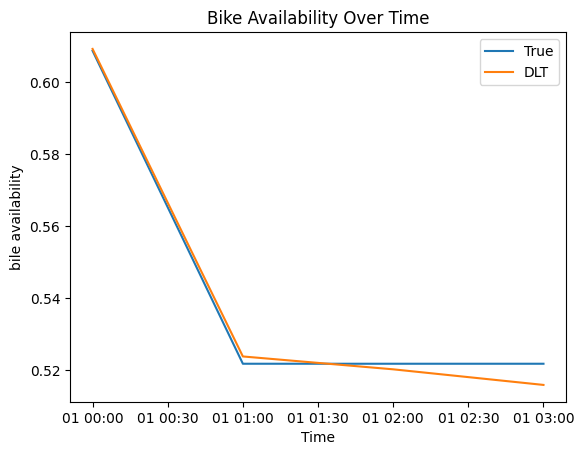

In [ ]:
import matplotlib.pyplot as plt

actual = predicted_df['actual'].tolist()
predicted_list = predicted_df['prediction'].tolist()
date_list = predicted_df['date'].tolist()
plt.plot(date_list, actual, label='True')
plt.plot(date_list, predicted_list, label='DLT')
plt.xlabel('Time')
plt.ylabel('bile availability')
plt.title('Bike Availability Over Time')
plt.legend()
plt.show()

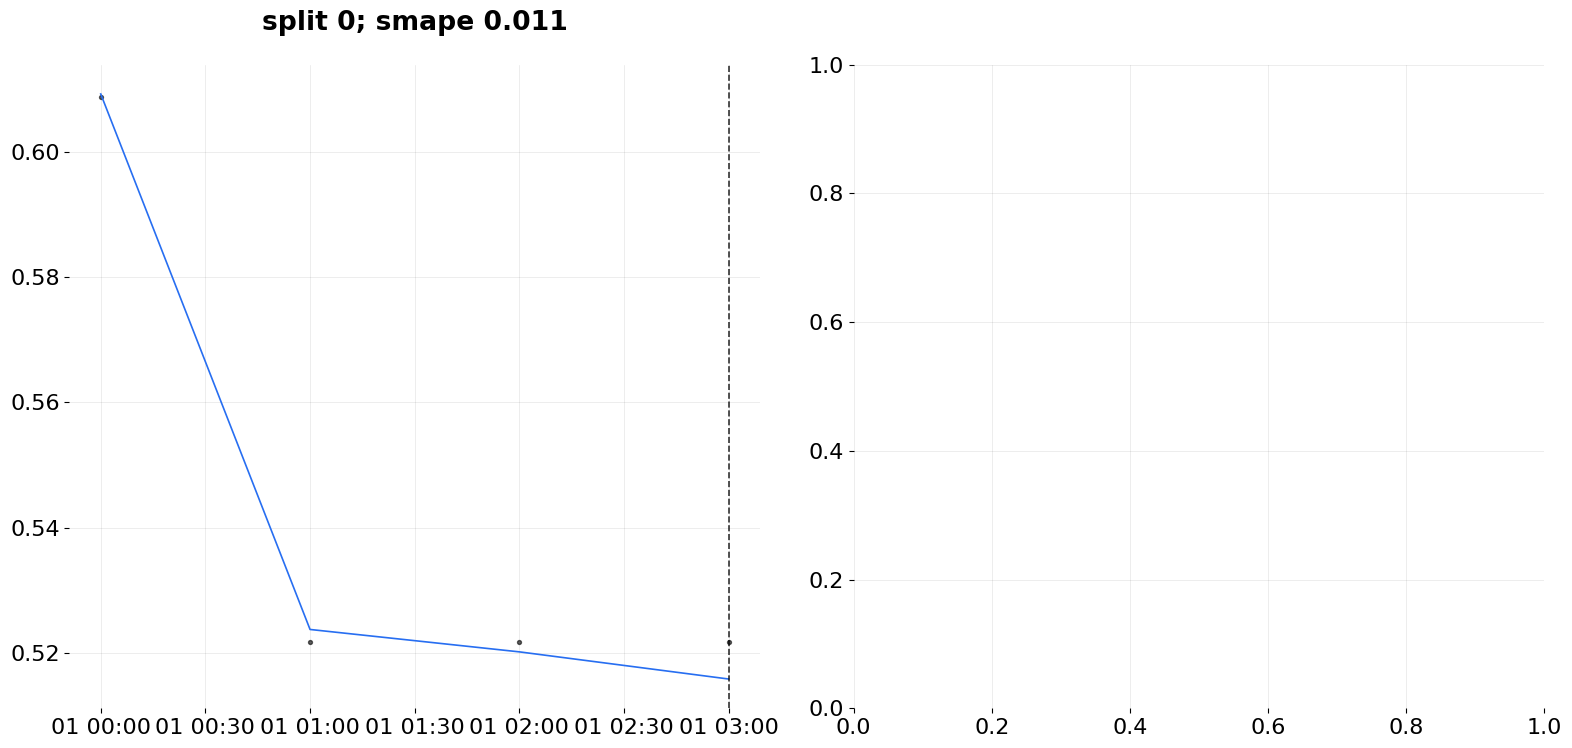

In [ ]:
plot_bt_predictions(predicted_df, metrics=smape, ncol=2, include_vline=True);

## Model Evaluation

In [ ]:
bt.score()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,metric_name,metric_values,is_training_metric
0,smape,0.011343,False
1,wmape,0.011279,False
2,mape,0.011279,False
3,mse,0.000035,False
4,mae,0.005885,False
5,rmsse,NaN,False


## Model Coefficients

In [ ]:
fitted_models = bt.get_fitted_models()
model_1 = fitted_models[0]

model_1.get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,Hour,Regular,-0.003549,-0.077436,0.050641,0.47,0.53
1,bikes_available,Regular,0.044336,-0.015350,0.098747,0.91,0.09


## Visualize train/test split

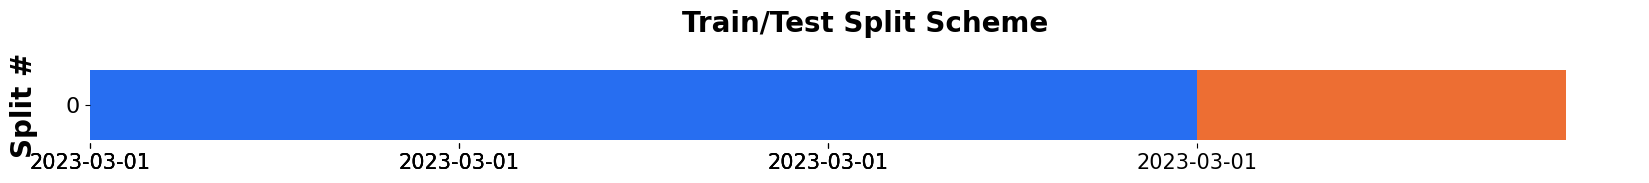

In [ ]:
ts_splitter = bt.get_splitter()
ts_splitter.plot()
plt.grid();